<a href="https://colab.research.google.com/github/sodiq-sulaimon/Preparations-for-TensorFlow-Developer-Certification/blob/main/Training_a_binary_classifier_with_the_Sarcasm_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a binary classifier with the Sarcasm Dataset

### Download the dataset

In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-10-25 12:25:52--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json.1’

sarcasm.json.1      100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2023-10-25 12:25:53 (87.3 MB/s) - ‘sarcasm.json.1’ saved [5643545/5643545]



In [2]:
import json

with open("sarcasm.json") as f:
  data = json.load(f)

sentences = []
labels = []

for item in data:
  sentences.append(item["headline"])
  labels.append(item["is_sarcastic"])

In [3]:
sentences[1], labels[1]

("the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 0)

In [4]:
len(sentences)

26709

### Hyperparameters

In [5]:
training_size = 20000

vocab_size = 10000
embedding_dim = 16
max_length = 32
padding_type = 'post'
trunc_type = 'post'
oov_tok = '<OOV>'

### Split the dataset

In [6]:
training_sentences = sentences[:training_size]
training_labels = labels[:training_size]

test_sentences = sentences[training_size:]
test_labels = labels[training_size:]

### Preprocessing the train and test sets

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(train_sequences, padding=padding_type,
                                 truncating=trunc_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test = pad_sequences(test_sequences, padding=padding_type,
               truncating=trunc_type, maxlen=max_length)


In [8]:
# Convert the labels to numpy arrays
import numpy as np

training_labels_final = np.array(training_labels)
test_labels_final = np.array(test_labels)

In [9]:
type(training_labels_final)

numpy.ndarray

### Build and compile the model

In [10]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train the model

In [12]:
num_epochs = 15

history = model.fit(padded_sequences, training_labels_final, epochs=num_epochs,
          validation_data=(padded_test, test_labels_final))

Epoch 1/15
625/625 [==============================] - 23s 27ms/step - loss: 0.5688 - accuracy: 0.6992 - val_loss: 0.4096 - val_accuracy: 0.8284
Epoch 2/15
625/625 [==============================] - 4s 7ms/step - loss: 0.3161 - accuracy: 0.8734 - val_loss: 0.3426 - val_accuracy: 0.8566
Epoch 3/15
625/625 [==============================] - 3s 5ms/step - loss: 0.2369 - accuracy: 0.9058 - val_loss: 0.3472 - val_accuracy: 0.8472
Epoch 4/15
625/625 [==============================] - 3s 5ms/step - loss: 0.1916 - accuracy: 0.9265 - val_loss: 0.3684 - val_accuracy: 0.8462
Epoch 5/15
625/625 [==============================] - 3s 5ms/step - loss: 0.1583 - accuracy: 0.9409 - val_loss: 0.3849 - val_accuracy: 0.8532
Epoch 6/15
625/625 [==============================] - 4s 6ms/step - loss: 0.1336 - accuracy: 0.9523 - val_loss: 0.4231 - val_accuracy: 0.8426
Epoch 7/15
625/625 [==============================] - 3s 5ms/step - loss: 0.1143 - accuracy: 0.9603 - val_loss: 0.4564 - val_accuracy: 0.8445
Epoc

### Visualize the results

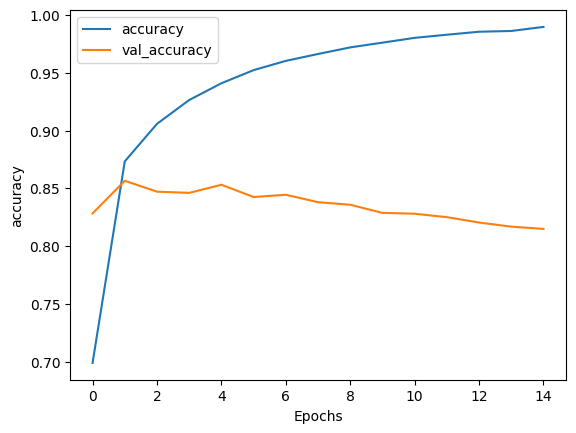

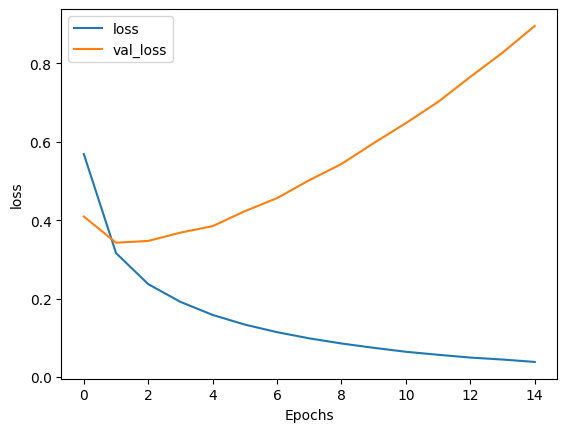

In [13]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Visualize Word Embeddings

In [14]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(10000, 16)


In [15]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [16]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>